#Setup

In [1]:
import tensorflow as tf
print(tf.__version__)


2.6.0


In [2]:
!nvidia-smi

Fri Sep 24 17:39:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

#Dataset and Preperation

In [4]:
!git clone https://github.com/thunderInfy/imagenet-5-categories

fatal: destination path 'imagenet-5-categories' already exists and is not an empty directory.


In [5]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


In [6]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [7]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [8]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [9]:
# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

#Utils

In [10]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [11]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2021-09-24 17:39:58--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py.2’

helpers.py.2        100%[===================>]     891  --.-KB/s    in 0s      

2021-09-24 17:39:58 (18.3 MB/s) - ‘helpers.py.2’ saved [891/891]

--2021-09-24 17:39:58--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘l

In [12]:
!sed -i '3 s/^/#/' helpers.py

In [13]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [14]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [15]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [16]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

#Training

  0%|          | 1/200 [00:25<1:24:31, 25.48s/it]

epoch: 1 loss: 4.830


  6%|▌         | 11/200 [02:35<40:53, 12.98s/it]

epoch: 11 loss: 4.092


 10%|█         | 21/200 [04:44<38:20, 12.85s/it]

epoch: 21 loss: 3.562


 16%|█▌        | 31/200 [06:54<36:33, 12.98s/it]

epoch: 31 loss: 3.156


 20%|██        | 41/200 [09:02<34:02, 12.84s/it]

epoch: 41 loss: 2.778


 26%|██▌       | 51/200 [11:11<31:57, 12.87s/it]

epoch: 51 loss: 2.496


 30%|███       | 61/200 [13:19<29:46, 12.86s/it]

epoch: 61 loss: 2.339


 36%|███▌      | 71/200 [15:28<27:38, 12.86s/it]

epoch: 71 loss: 2.181


 40%|████      | 81/200 [17:37<25:30, 12.86s/it]

epoch: 81 loss: 2.088


 46%|████▌     | 91/200 [19:45<23:21, 12.86s/it]

epoch: 91 loss: 2.015


 50%|█████     | 101/200 [21:54<21:13, 12.87s/it]

epoch: 101 loss: 1.939


 56%|█████▌    | 111/200 [24:02<19:02, 12.84s/it]

epoch: 111 loss: 1.883


 60%|██████    | 121/200 [26:11<16:54, 12.85s/it]

epoch: 121 loss: 1.830


 66%|██████▌   | 131/200 [28:19<14:47, 12.86s/it]

epoch: 131 loss: 1.786


 70%|███████   | 141/200 [30:28<12:37, 12.84s/it]

epoch: 141 loss: 1.752


 76%|███████▌  | 151/200 [32:36<10:29, 12.84s/it]

epoch: 151 loss: 1.716


 80%|████████  | 161/200 [34:44<08:21, 12.85s/it]

epoch: 161 loss: 1.693


 86%|████████▌ | 171/200 [36:53<06:13, 12.86s/it]

epoch: 171 loss: 1.677


 90%|█████████ | 181/200 [39:02<04:04, 12.89s/it]

epoch: 181 loss: 1.665


 96%|█████████▌| 191/200 [41:11<01:56, 12.95s/it]

epoch: 191 loss: 1.650


100%|██████████| 200/200 [43:07<00:00, 12.94s/it]


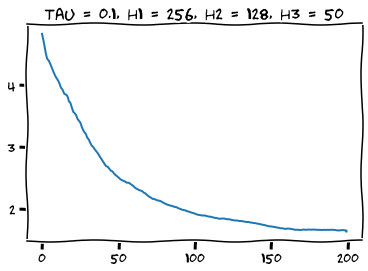

In [17]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [18]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"
filename

'20210924-182308resnet_simclr.h5'

In [19]:
resnet_simclr.save_weights(filename)

# Linear Eval Using Simclr Weights

## Setup

In [20]:

# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)


##Dataset and Preperation (Linear)

In [21]:
# Train and test image paths
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [22]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [23]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [24]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 125/125 [00:00<00:00, 200.98it/s]


(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 199.65it/s]


(250, 224, 224, 3) (250,)


In [25]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Weights and Utils

In [26]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(filename)
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [27]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [28]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [29]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [30]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [31]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
2/2 [==============================] - 1s 186ms/step - loss: 4.1679 - accuracy: 0.1920 - val_loss: 3.9726 - val_accuracy: 0.1840
Epoch 2/35
2/2 [==============================] - 0s 28ms/step - loss: 3.8541 - accuracy: 0.1920 - val_loss: 3.7223 - val_accuracy: 0.1800
Epoch 3/35
2/2 [==============================] - 0s 29ms/step - loss: 3.5743 - accuracy: 0.2000 - val_loss: 3.4941 - val_accuracy: 0.1840
Epoch 4/35
2/2 [==============================] - 0s 26ms/step - loss: 3.3079 - accuracy: 0.2320 - val_loss: 3.2930 - val_accuracy: 0.1960
Epoch 5/35
2/2 [==============================] - 0s 27ms/step - loss: 3.0771 - accuracy: 0.2320 - val_loss: 3.1167 - val_accuracy: 0.1880
Epoch 6/35
2/2 [==============================] - 0s 27ms/step - loss: 2.8808 - accuracy: 0.2240 - val_loss: 2.9642 - val_accuracy: 0.1760
Epoch 7/35
2/2 [==============================] - 0s 29ms/step - loss: 2.6941 - accuracy: 0.2480 - val_loss: 2.8351 - val_accuracy: 0.2000
Epoch 8/35
2/2 [==========

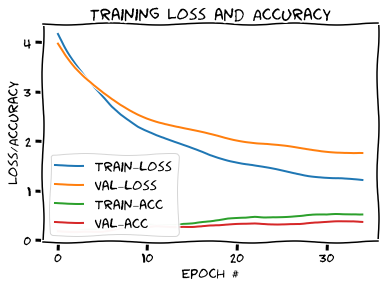

In [32]:
# Linear model

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [33]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


Epoch 1/35
2/2 [==============================] - 0s 165ms/step - loss: 3.7740 - accuracy: 0.2720 - val_loss: 2.9163 - val_accuracy: 0.3000
Epoch 2/35
2/2 [==============================] - 0s 26ms/step - loss: 3.1902 - accuracy: 0.2800 - val_loss: 2.4538 - val_accuracy: 0.3280
Epoch 3/35
2/2 [==============================] - 0s 26ms/step - loss: 2.7226 - accuracy: 0.3120 - val_loss: 2.1181 - val_accuracy: 0.3400
Epoch 4/35
2/2 [==============================] - 0s 28ms/step - loss: 2.3768 - accuracy: 0.3680 - val_loss: 1.9028 - val_accuracy: 0.3760
Epoch 5/35
2/2 [==============================] - 0s 26ms/step - loss: 2.1371 - accuracy: 0.3440 - val_loss: 1.7765 - val_accuracy: 0.3840
Epoch 6/35
2/2 [==============================] - 0s 26ms/step - loss: 1.9940 - accuracy: 0.3600 - val_loss: 1.7065 - val_accuracy: 0.3880
Epoch 7/35
2/2 [==============================] - 0s 29ms/step - loss: 1.9142 - accuracy: 0.3600 - val_loss: 1.6669 - val_accuracy: 0.3880
Epoch 8/35
2/2 [==========

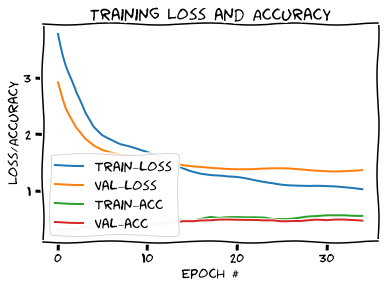

In [34]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [35]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


Epoch 1/35
2/2 [==============================] - 0s 152ms/step - loss: 2.7962 - accuracy: 0.1520 - val_loss: 2.1594 - val_accuracy: 0.1440
Epoch 2/35
2/2 [==============================] - 0s 29ms/step - loss: 2.1490 - accuracy: 0.2400 - val_loss: 1.9570 - val_accuracy: 0.3160
Epoch 3/35
2/2 [==============================] - 0s 29ms/step - loss: 1.8118 - accuracy: 0.3280 - val_loss: 1.4727 - val_accuracy: 0.3720
Epoch 4/35
2/2 [==============================] - 0s 27ms/step - loss: 1.4479 - accuracy: 0.4000 - val_loss: 1.5791 - val_accuracy: 0.3440
Epoch 5/35
2/2 [==============================] - 0s 29ms/step - loss: 1.4247 - accuracy: 0.4480 - val_loss: 1.3328 - val_accuracy: 0.4200
Epoch 6/35
2/2 [==============================] - 0s 28ms/step - loss: 1.1588 - accuracy: 0.5280 - val_loss: 1.3158 - val_accuracy: 0.4880
Epoch 7/35
2/2 [==============================] - 0s 28ms/step - loss: 1.1283 - accuracy: 0.5760 - val_loss: 1.3156 - val_accuracy: 0.5040
Epoch 8/35
2/2 [==========

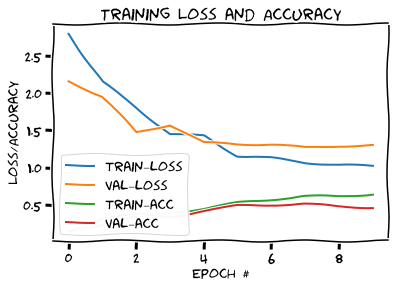

In [36]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

##Visualizations

In [37]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


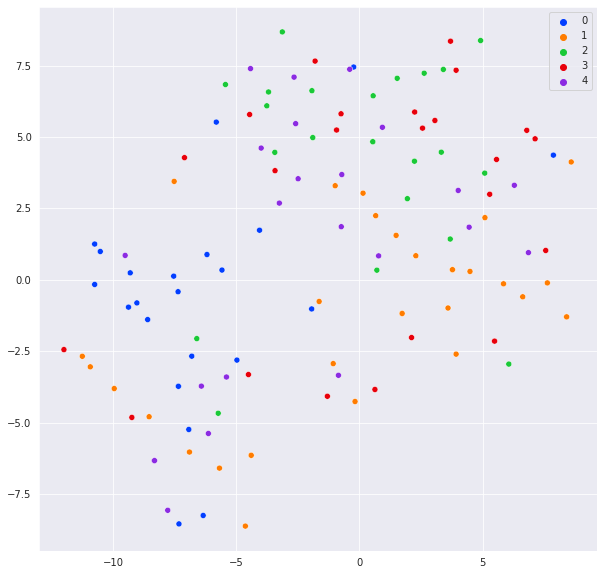

In [38]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


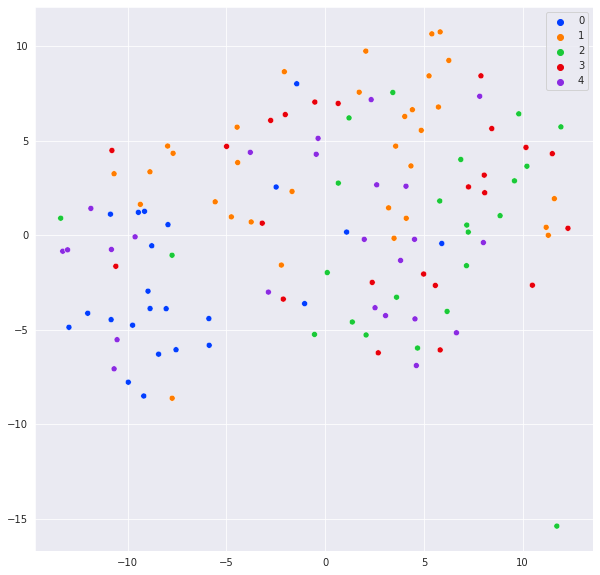

In [39]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


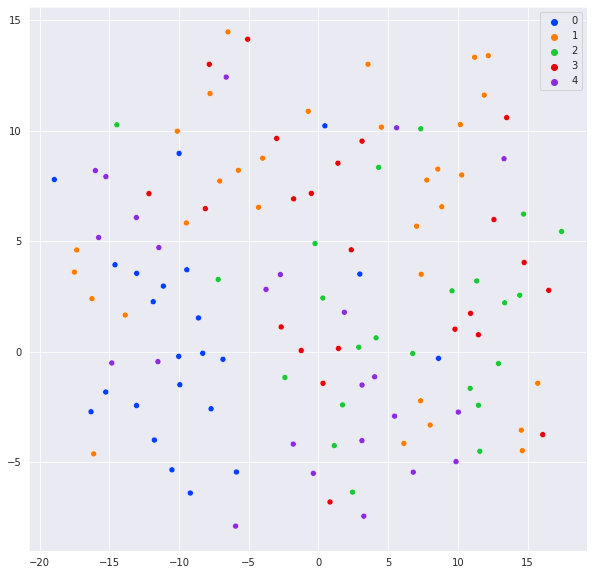

In [40]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)